In [200]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import RFE

In [201]:
# load dataset
data = pd.read_csv('heloc_dataset_v1.csv',header = 0)
data.head(10)

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80
5,Bad,59,137,11,78,31,0,0,91,1,...,47,0,0,0,62,93,12,4,3,94
6,Good,54,88,7,37,25,0,0,92,9,...,58,0,4,4,89,76,7,7,2,100
7,Good,68,148,7,65,17,0,0,83,31,...,44,0,0,0,28,48,2,2,2,40
8,Bad,59,324,2,138,24,0,0,85,5,...,26,0,1,1,68,-8,7,1,3,90
9,Bad,61,79,4,36,19,0,0,95,5,...,26,0,6,6,31,86,5,3,1,62


In [202]:
# change target variable to labels
data['RiskPerformance'] = data['RiskPerformance'].replace("Bad",0)
data['RiskPerformance'] = data['RiskPerformance'].replace("Good",1)

# deal with special values
# - remove observations without any record
data = data[data.ExternalRiskEstimate!=-9]

# - impute median for observations lack record for observations lacking certain records
for i in data.columns:
    data[i] = data[i].replace(-7,np.nan)
    data[i] = data[i].replace(-8,np.nan)

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data = pd.DataFrame(imputer.fit_transform(data),columns= data.columns)

# convert categorical variables to dummy variables
data = pd.get_dummies(data, columns=['MaxDelq2PublicRecLast12M'], drop_first=False)
data = pd.get_dummies(data, columns=['MaxDelqEver'], drop_first=False)   

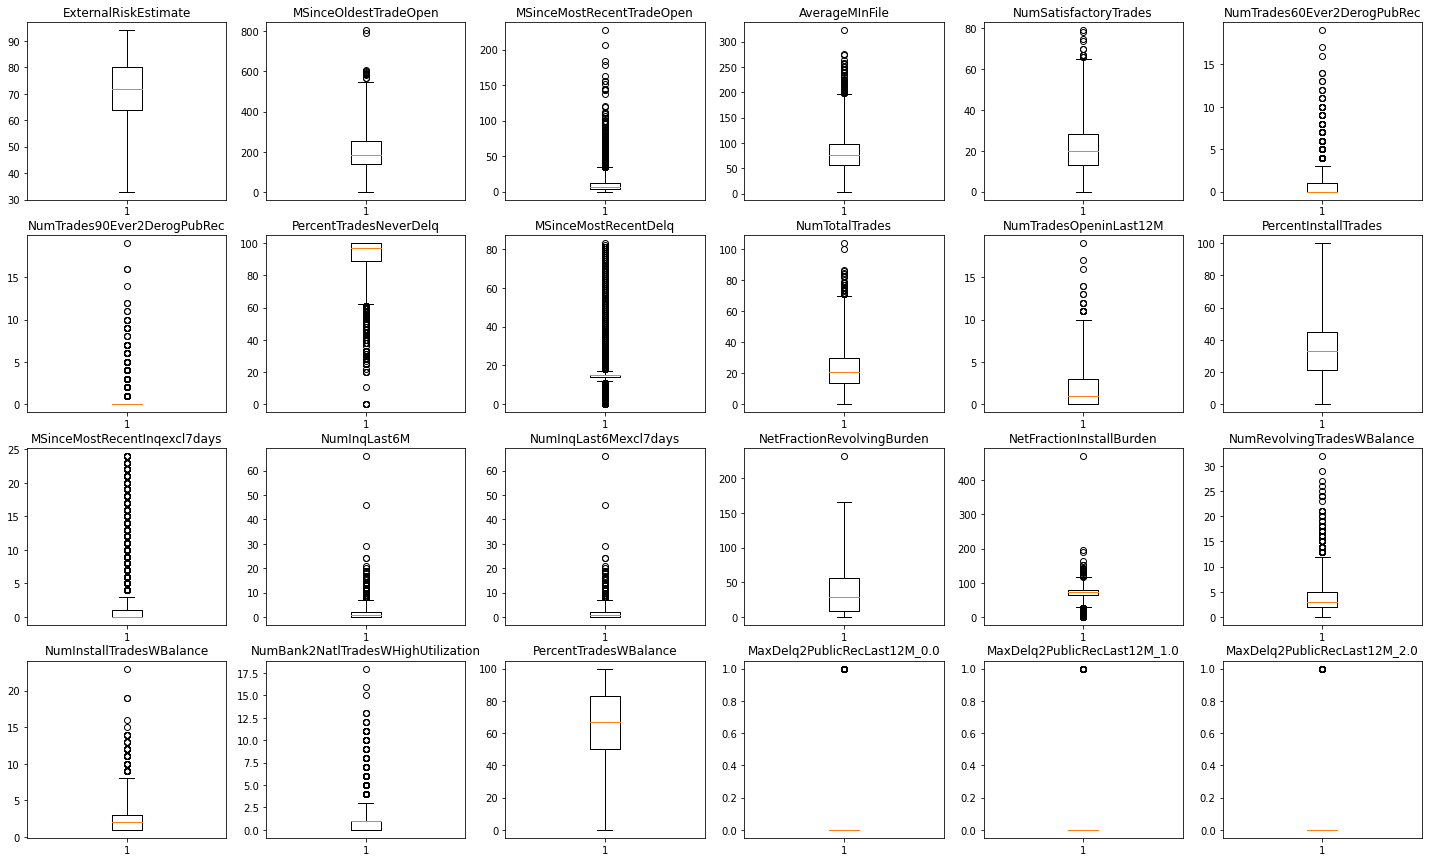

In [203]:
# detect outliers
fig, axs = plt.subplots(4,6,figsize=(25,15))
for i in range(4):
    for j in range(6):
        try:
            axs[i,j].boxplot(data.iloc[:,i+j+i*5+1],whis=2.5)
            axs[i,j].title.set_text(data.columns[i+j+i*5+1])
        except:
            break
plt.savefig(fname='boxplot')

In [166]:
# remove obvious outliers
data = data[(data['NumInqLast6M']<60)&(data['NumInqLast6Mexcl7days']<60)&\
      (data['NetFractionRevolvingBurden']<200)&(data['NetFractionInstallBurden']<400)]

In [167]:
# check  the data is balanced
data['RiskPerformance'].value_counts()

0.0    5125
1.0    4733
Name: RiskPerformance, dtype: int64

In [168]:
# check correlation between features
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # show all ticks
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

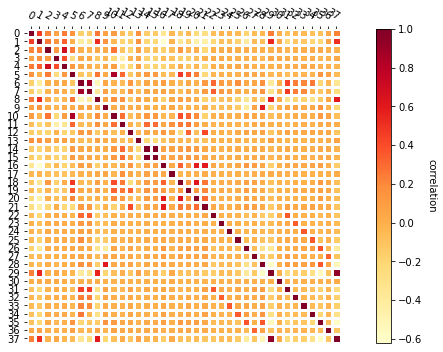

In [169]:
fig, ax = plt.subplots(figsize=(10,5))

im, cbar = heatmap(data.corr(), range(38), range(38), ax=ax,
                   cmap="YlOrRd", cbarlabel="correlation")

fig.tight_layout()
plt.show()

In [170]:
# pd.set_option('display.max_columns', 15)
# load X and y
X = data.iloc[:,1:]
y = data.iloc[:,0]

In [171]:
def evaluate_model(X, y, model, model_name, params):
    # hyper-parameter tuning，using model and input params to choose the best model
    clf = GridSearchCV(model, params, cv=10)
    
    # split training set and test set
    np.random.seed(1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # feature scaling
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # evaluate the test error using the best classifier and the test data
    clf.fit(X_train, y_train)
    params = clf.best_params_
    Score = clf.score(X_test, y_test) 
    cvres = clf.cv_results_ 
    cvscore = cvres['mean_test_score'][clf.best_index_] 
    macro_precision, macro_recall, macro_f1_score, macro_support=\
    precision_recall_fscore_support(y_test, clf.predict(X_test), average='macro') 
    micro_precision, micro_recall, micro_f1_score, micro_support=\
    precision_recall_fscore_support(y_test, clf.predict(X_test), average='micro') 
    
    #9.6 return a dictionary
    d = {'Classifier': model_name,'param':params,'Test Score': Score, 'CV Score':cvscore, \
         'Precision(Macro)': macro_precision, 'Precision(Micro)': micro_precision,\
         'Recall(Macro)': macro_recall, 'Recall(Micro)': micro_recall,\
         'F1 Score(Macro)': macro_f1_score, 'F1 Score(Micro)': micro_f1_score}

    
    return d
    pass

In [172]:
def init_classifiers():
    return([(SVC(), model_names[0], param_grid_svc), 
            (LogisticRegression(), model_names[1], param_grid_logistic),
            (KNeighborsClassifier(), model_names[2], param_grid_knn),
            (GaussianNB(), model_names[3], param_grid_nb),
            (DecisionTreeClassifier(), model_names[4], param_grid_tree),
            (RandomForestClassifier(), model_names[5], param_grid_rf),
            (AdaBoostClassifier(), model_names[6], param_grid_boost),
            (MLPClassifier(),model_names[7],param_grid_MLP)])

# 'model_names' contains the names  that we will use for the above classifiers
model_names = ['SVM','LR','KNN','NB','Tree','RF','Boosting','MLP']

# the training parameters of each model
param_grid_svc = [{'C':[0.1],'kernel':['linear'], 'max_iter':[-1],'random_state':[1]}]
param_grid_logistic = [{'C':[0.1], 'penalty':['l1','l2'],'random_state':[1]}]
param_grid_knn = [{},{'n_neighbors':list(range(1,31))}]
param_grid_nb = [{}]
param_grid_tree = [{'random_state':[1]},{'criterion':['gini'], 'max_depth':list(range(2,10)), \
                    'min_samples_split':list(range(3,7)),'random_state':[1]}]
param_grid_rf = [{'random_state':[1]},{'n_estimators':[98], 'bootstrap':[True],'random_state':[1]}]
param_grid_boost = [{'random_state':[1]},{'n_estimators':[98],\
                     'learning_rate':[1.0],'random_state':[1]}]
param_grid_MLP = [{'hidden_layer_sizes':[(50,),(100,),(200,)],'solver':['sgd'],'random_state':[1],\
                   'activation':['tanh'],'learning_rate':['constant'],'alpha':[1.0]}]



In [173]:
res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= evaluate_model(X, y, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

,Classifier,param,Test Score,CV Score,Precision(Macro),Precision(Micro),Recall(Macro),Recall(Micro),F1 Score(Macro),F1 Score(Micro)
0,NB,{},0.548682,0.579505,0.635383,0.548682,0.570110,0.548682,0.498105,0.548682
1,Tree,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.693205,0.709614,0.693134,0.693205,0.689184,0.693205,0.689583,0.693205
2,KNN,{'n_neighbors': 26},0.704868,0.723943,0.703813,0.704868,0.703957,0.704868,0.703879,0.704868
3,Boosting,"{'learning_rate': 1.0, 'n_estimators': 98, 'ra...",0.708418,0.735483,0.708104,0.708418,0.708852,0.708418,0.708039,0.708418
4,LR,"{'C': 0.1, 'penalty': 'l2', 'random_state': 1}",0.712982,0.738146,0.712695,0.712982,0.713464,0.712982,0.712620,0.712982
5,SVM,"{'C': 0.1, 'kernel': 'linear', 'max_iter': -1,...",0.714503,0.737260,0.714042,0.714503,0.714774,0.714503,0.714067,0.714503
6,MLP,"{'activation': 'tanh', 'alpha': 1.0, 'hidden_l...",0.718053,0.740049,0.717402,0.718053,0.718058,0.718053,0.717515,0.718053
7,RF,{'random_state': 1},0.721602,0.727874,0.720619,0.721602,0.720846,0.721602,0.720718,0.721602


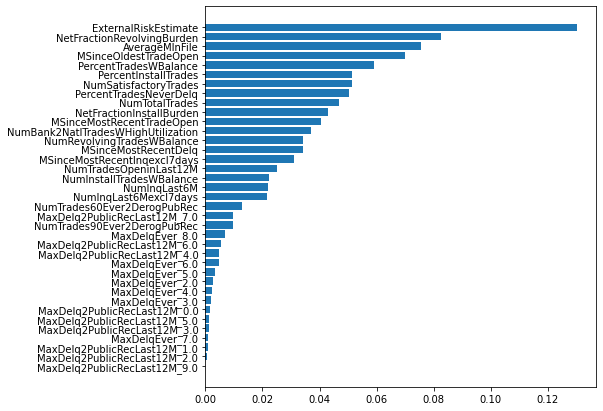

In [143]:
# split training set and test set
np.random.seed(1)
X_train_original, X_test_original, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# feature scaling
scaler = StandardScaler()
scaler.fit(X_train_original)
X_train = scaler.transform(X_train_original)
X_test = scaler.transform(X_test_original)

rf = RandomForestClassifier(random_state=1,n_estimators=98)
rf.fit(X_train, y_train)

def f_importances(importance, names):
    imp = importance
    imp,names = zip(*sorted(zip(imp,names)))
    plt.figure(figsize=(7,7))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()
    
f_importances(rf.feature_importances_, data.columns[1:])

In [181]:
# explaination with LME
import lime
import lime.lime_tabular
feature_names = data.columns[1:]
labels = data.iloc[:,0]
class_names = np.array([0,1])
features = data.iloc[:,1:]

In [182]:
categorical_names = {}
categorical_features = list(range(21,37))
for feature in categorical_features:
    categorical_names[feature] = np.array([0,1])

In [183]:
predict_fn = lambda x: rf.predict_proba(scaler.transform(x)).astype(float)

In [186]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_original.values ,feature_names = feature_names,class_names=class_names,
                                                   categorical_features=categorical_features, 
                                                   categorical_names=categorical_names, kernel_width=3)

In [198]:
i = 20
exp = explainer.explain_instance(X_test_original.values[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)